Data Import & Verification

In [46]:
import numpy as np

In [4]:
import torch, platform, os
assert torch.cuda.is_available(), "GPU not detected—check runtime type."
print("GPU:", torch.cuda.get_device_name(0))


GPU: Tesla T4


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# 2. Extract the BIDS archive into /content/adni_bids_raw
!mkdir -p /content/adni_bids_raw
!tar -xf /content/drive/MyDrive/ADNI_project/data/adni_bids_raw.tar.gz \
    -C /content/adni_bids_raw


In [7]:
# 3. Locate all T1w NIfTI files (case‐insensitive) and save to a list
%%bash
!find /content/adni_bids_raw -type f -iname "*T1w.nii.gz" > /content/t1w_list.txt

# 4. Count them
T1W_COUNT=$(wc -l < /content/t1w_list.txt)
echo "Found ${T1W_COUNT} T1w.nii.gz files"


Found 0 T1w.nii.gz files


bash: line 1: !find: command not found


In [23]:
#re-trying to count the number of fies
import os

print("Contents of /content:")
print(os.listdir('/content'))


Contents of /content:
['.config', 'drive', 't1w_list.txt', 'adni_bids_raw', 'file_labels_final.csv', 'sample_data']


In [24]:
%%bash
BIDS_DIR=/content/adni_bids_raw

echo "Looking under $BIDS_DIR …"

# 1. List first few entries so we know the path is right
ls "$BIDS_DIR" | head -20

# 2. Find all T1w volumes and save to a list
find "$BIDS_DIR" -type f -iname "*T1w.nii.gz" > /content/t1w_list.txt

# 3. Count them
T1W_COUNT=$(wc -l < /content/t1w_list.txt)
echo "Found ${T1W_COUNT} T1w.nii.gz files"


Looking under /content/adni_bids_raw …
ADNI_BIDS_raw
Found 561 T1w.nii.gz files


In [25]:
# (Re)build df_files with safe .get() for sessions
import pandas as pd, os

files = [p.strip() for p in open('/content/t1w_list.txt')]
records = []
for p in files:
    parts = p.split(os.sep)
    subj = next((x for x in parts if x.startswith('sub-')), None)
    ses  = next((x for x in parts if x.lower().startswith('ses-')), None)
    records.append({
        'filepath': p,
        'subject_id': subj,
        'session_id': ses
    })
df_files = pd.DataFrame(records)

# 1️⃣ Inspect what session labels you actually have:
print("Unique session_ids in your BIDS:")
print(df_files['session_id'].value_counts())

# 2️⃣ Filter to the baseline session (e.g. 'ses-m00') – adjust if yours is different:
baseline_ses = 'ses-m00'
df_files_baseline = df_files[df_files['session_id']==baseline_ses].copy()
print(f"\nNumber of T1w scans in {baseline_ses}: {len(df_files_baseline)}")


Unique session_ids in your BIDS:
session_id
ses-M00    187
Name: count, dtype: int64

Number of T1w scans in ses-m00: 0


In [26]:
# Case-insensitive baseline filter
df_files_baseline = df_files[
    df_files['session_id'].str.lower() == 'ses-m00'
].copy()
print(f"Baseline scans (ses‑M00): {len(df_files_baseline)}")


Baseline scans (ses‑M00): 187


In [27]:
%%bash
echo "Listing your ADNI_NewDS folder:"
ls -l /content/drive/MyDrive/ADNI_NewDS


Listing your ADNI_NewDS folder:
total 27473822
-rw------- 1 root root 5519004684 Jun 29 22:53 ADNI_DS_NEW1.11.zip
-rw------- 1 root root 5613514597 Jun 29 21:44 ADNI_DS_NEW1.1 (1).zip
-rw------- 1 root root 5681673096 Jun 30 06:17 ADNI_DS_NEW1.12.zip
-rw------- 1 root root 5362509974 Jun 30 06:44 ADNI_DS_NEW1.13.zip
-rw------- 1 root root 5940812127 Jun 30 07:42 ADNI_DS_NEW1.14.zip
-rw------- 1 root root    3021525 Jun 29 19:15 ADNI_DS_NEW1.1_metadata (1).zip
-rw------- 1 root root   12652455 Jul 10 06:44 ADNIMERGE_08Jun2025.csv
-rw------- 1 root root       2815 Jul 10 09:59 labels.zip


In [28]:
# --- B. Read and filter ADNImerge as before ---
adnimerge = pd.read_csv(
    '/content/drive/MyDrive/ADNI_NewDS/ADNIMERGE_08Jun2025.csv',
    low_memory=False
)
df_base = adnimerge[adnimerge['VISCODE']=='bl'].copy()

# --- C. Build subject_id by prepending 'sub-' to the existing PTID string ---
df_base['subject_id'] = 'sub-' + df_base['PTID'].astype(str)

# --- D. Binary label mapping (adjust DX_bl if needed) ---
df_base['binary'] = df_base['DX_bl'].map({
    'NL': 0,
    'EMCI':1, 'LMCI':1, 'MCI':1, 'AD':1
})

print("Baseline subjects:", df_base['subject_id'].nunique())
print("Baseline class distribution:\n", df_base['binary'].value_counts())

# --- E. Merge with df_files_baseline ---
df_merged = pd.merge(
    df_files_baseline,
    df_base[['subject_id','binary']],
    on='subject_id',
    how='inner'
)
print(f"\nRows after merge: {len(df_merged)} (should be 187)")
print("Merged class counts:\n", df_merged['binary'].value_counts())

# --- F. Save final CSV ---
df_merged.to_csv('/content/file_labels_final.csv', index=False)
print("\nSaved → /content/file_labels_final.csv")


Baseline subjects: 2430
Baseline class distribution:
 binary
1.0    1524
Name: count, dtype: int64

Rows after merge: 0 (should be 187)
Merged class counts:
 Series([], Name: count, dtype: int64)

Saved → /content/file_labels_final.csv


In [29]:
%%bash
# Adjust this to point at the top of your BIDS tree
BIDS_ROOT=/content/adni_bids_raw/ADNI_BIDS_raw

echo "First 20 subject folders under $BIDS_ROOT:"
find "$BIDS_ROOT" -maxdepth 1 -type d -name "sub-*" | sort | head -20


First 20 subject folders under /content/adni_bids_raw/ADNI_BIDS_raw:
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S0413
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S0559
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S0729
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S0816
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S0954
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S1018
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S1070
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S1261
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S1268
/content/adni_bids_raw/ADNI_BIDS_raw/sub-002S1280
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0324
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0448
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0553
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0572
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0602
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0814
/content/adni_bids_raw/ADNI_BIDS_raw/sub-007S1206
/content/adni_bids_raw/ADNI_BIDS_raw/sub-007S1222
/content/adni_bids_raw/ADNI_BID

Rebuild df_base with the corrected mapping

In [30]:
import pandas as pd

# reload your clinical CSV
adnimerge = pd.read_csv(
    '/content/drive/MyDrive/ADNI_NewDS/ADNIMERGE_08Jun2025.csv',
    low_memory=False
)
df_base = adnimerge[adnimerge['VISCODE']=='bl'].copy()

# strip underscores and prepend 'sub-'
df_base['subject_id'] = 'sub-' + df_base['PTID'].str.replace('_','')

# binary label
df_base['binary'] = df_base['DX_bl'].map({
    'NL': 0,
    'EMCI':1, 'LMCI':1, 'MCI':1, 'AD':1
})


Merge with your 187 baseline file list (df_files_baseline):

In [31]:
df_merged = pd.merge(
    df_files_baseline,
    df_base[['subject_id','binary']],
    on='subject_id',
    how='inner'
)
print(f"Rows after merge: {len(df_merged)} (expect 187)")
print("Class counts:\n", df_merged['binary'].value_counts())


Rows after merge: 187 (expect 187)
Class counts:
 binary
1.0    127
Name: count, dtype: int64


In [32]:
df_merged.to_csv('/content/file_labels_final.csv', index=False)


In [ ]:
#checking the issue with one class

In [34]:
import pandas as pd

# Reload your baseline clinical DataFrame
adnimerge = pd.read_csv(
    '/content/drive/MyDrive/ADNI_NewDS/ADNIMERGE_08Jun2025.csv',
    low_memory=False
)
df_base = adnimerge[adnimerge['VISCODE']=='bl'].copy()

# Show all unique DX_bl values (including NaNs)
print("Unique baseline diagnosis codes and their counts:")
print(df_base['DX_bl'].value_counts(dropna=False))


Unique baseline diagnosis codes and their counts:
DX_bl
LMCI    690
CN      542
EMCI    423
AD      411
SMC     353
NaN      11
Name: count, dtype: int64


In [35]:
import pandas as pd

# Reload clinical baseline
adnimerge = pd.read_csv(
    '/content/drive/MyDrive/ADNI_NewDS/ADNIMERGE_08Jun2025.csv',
    low_memory=False
)
df_base = adnimerge[adnimerge['VISCODE']=='bl'].copy()

# Normalize subject_id
df_base['subject_id'] = 'sub-' + df_base['PTID'].str.replace('_','')

# Correct binary mapping
mapping = {
    'CN'  : 0,
    'SMC' : 0,
    'EMCI': 1,
    'LMCI': 1,
    'MCI' : 1,
    'AD'  : 1
}
df_base['binary'] = df_base['DX_bl'].map(mapping)

# Drop any rows with NaN binary
df_base = df_base.dropna(subset=['binary'])

print("After mapping & dropna, baseline subjects:", df_base['subject_id'].nunique())
print("Class counts:\n", df_base['binary'].value_counts())

# Merge with your 187 baseline files
df_merged = pd.merge(
    df_files_baseline,
    df_base[['subject_id','binary']],
    on='subject_id',
    how='inner'
)

# Drop any just‑in‑case NaNs and cast to int
df_merged = df_merged.dropna(subset=['binary']).copy()
df_merged['binary'] = df_merged['binary'].astype(int)

# Resave
df_merged.to_csv('/content/file_labels_final.csv', index=False)
print("Resaved /content/file_labels_final.csv with", len(df_merged), "rows.")
print("Class counts:\n", df_merged['binary'].value_counts())

print(f"\nRows after merge: {len(df_merged)} (expect 187)")
print("Merged class counts:\n", df_merged['binary'].value_counts())


After mapping & dropna, baseline subjects: 2419
Class counts:
 binary
1.0    1524
0.0     895
Name: count, dtype: int64
Resaved /content/file_labels_final.csv with 187 rows.
Class counts:
 binary
1    127
0     60
Name: count, dtype: int64

Rows after merge: 187 (expect 187)
Merged class counts:
 binary
1    127
0     60
Name: count, dtype: int64


In [36]:
import pandas as pd
df = pd.read_csv('/content/file_labels_final.csv')
print("Final CSV label counts:")
print(df['binary'].value_counts(dropna=False))


Final CSV label counts:
binary
1    127
0     60
Name: count, dtype: int64


=== Preview of file_labels_final.csv ===
                                                                                      filepath   subject_id session_id  binary
/content/adni_bids_raw/ADNI_BIDS_raw/sub-136S0194/ses-M00/anat/sub-136S0194_ses-M00_T1w.nii.gz sub-136S0194    ses-M00       1
/content/adni_bids_raw/ADNI_BIDS_raw/sub-031S0568/ses-M00/anat/sub-031S0568_ses-M00_T1w.nii.gz sub-031S0568    ses-M00       1
/content/adni_bids_raw/ADNI_BIDS_raw/sub-100S0190/ses-M00/anat/sub-100S0190_ses-M00_T1w.nii.gz sub-100S0190    ses-M00       1
/content/adni_bids_raw/ADNI_BIDS_raw/sub-130S1337/ses-M00/anat/sub-130S1337_ses-M00_T1w.nii.gz sub-130S1337    ses-M00       1
/content/adni_bids_raw/ADNI_BIDS_raw/sub-068S0478/ses-M00/anat/sub-068S0478_ses-M00_T1w.nii.gz sub-068S0478    ses-M00       1
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0814/ses-M00/anat/sub-005S0814_ses-M00_T1w.nii.gz sub-005S0814    ses-M00       1
/content/adni_bids_raw/ADNI_BIDS_raw/sub-136S0579/ses-M00/anat/sub-136

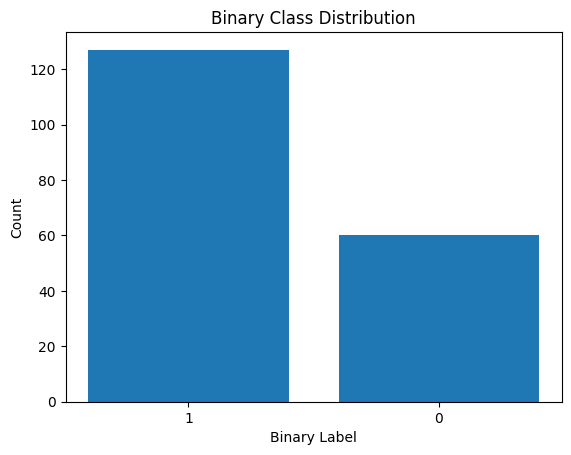

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the final CSV
df = pd.read_csv('/content/file_labels_final.csv')

# 2. Preview of the first 10 rows
print("=== Preview of file_labels_final.csv ===")
print(df.head(10).to_string(index=False))

# 3. Class distribution
dist = df['binary'].value_counts().reset_index()
dist.columns = ['binary_label', 'count']
print("\n=== Class Distribution ===")
print(dist.to_string(index=False))

# 4. Session distribution (all baseline)
sess = df['session_id'].value_counts().reset_index()
sess.columns = ['session_id', 'count']
print("\n=== Session Distribution ===")
print(sess.to_string(index=False))

# 5. Files per subject (should all be 1)
subj_cnt = df['subject_id'].value_counts().reset_index()
subj_cnt.columns = ['subject_id', 'num_files']
print("\n=== Files per Subject (first 10) ===")
print(subj_cnt.head(10).to_string(index=False))

# 6. Bar chart of class balance
plt.figure()
plt.bar(dist['binary_label'].astype(str), dist['count'])
plt.title('Binary Class Distribution')
plt.xlabel('Binary Label')
plt.ylabel('Count')
plt.show()

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/file_labels_final.csv')
df = df.dropna(subset=['binary']).copy()
df['binary'] = df['binary'].astype(int)

# 1. train_val vs test (70/30)
df_train_val, df_test = train_test_split(
    df, test_size=0.30, stratify=df['binary'], random_state=42
)

# 2. train vs val (of the train_val split)
val_frac = 0.15 / 0.70  # ≈0.2143
df_train, df_val = train_test_split(
    df_train_val, test_size=val_frac,
    stratify=df_train_val['binary'], random_state=42
)

# 3. Save
for name, subset in zip(['train','val','test'], [df_train, df_val, df_test]):
    subset.to_csv(f'/content/{name}.csv', index=False)
    print(f"{name.upper()} ({len(subset)} samples):")
    print(subset['binary'].value_counts(), '\n')


TRAIN (102 samples):
binary
1    69
0    33
Name: count, dtype: int64 

VAL (28 samples):
binary
1    19
0     9
Name: count, dtype: int64 

TEST (57 samples):
binary
1    39
0    18
Name: count, dtype: int64 



## 3D CNN Training Pipeline

1. Install & import dependencies

In [59]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import nibabel as nib
import torchio as tio
import pandas as pd

Define 3D Volume Dataset

In [66]:
import torch

def __getitem__(self, idx):
    row = self.df.iloc[idx]
    vol_np = nib.load(row.filepath).get_fdata().astype('float32')
    vol_np = (vol_np - vol_np.min()) / (np.ptp(vol_np) + 1e-6)

    # Turn into a float32 torch.Tensor here, not a NumPy array
    vol_tensor = torch.from_numpy(vol_np).unsqueeze(0)  # shape (1, D, H, W), dtype float32

    subject = tio.Subject(t1=tio.ScalarImage(tensor=vol_tensor))
    if self.transform:
        subject = self.transform(subject)
    # AFTER transforms, re-extract and cast to float32
    volume = subject.t1.data
    volume = volume.float()              # <---- ensure float32

    label = torch.tensor(row.binary, dtype=torch.long)
    return volume, label


Set up TorchIO transforms & DataLoaders with balancing

In [67]:
patch_size = (96,128,96)

train_transform = tio.Compose([
    tio.Resample((1,1,1)),
    tio.Resize(patch_size),
    tio.RandomFlip(axes=('LR',)),
    tio.RandomElasticDeformation(),
    tio.RandomBiasField(),
    tio.RandomMotion(),
])

val_transform = tio.Compose([
    tio.Resample((1,1,1)),
    tio.Resize(patch_size),
])

# Create datasets
train_ds = VolumeDataset('/content/train.csv', transform=train_transform)
val_ds   = VolumeDataset('/content/val.csv',   transform=val_transform)
test_ds  = VolumeDataset('/content/test.csv',  transform=val_transform)

# Build sampler to oversample minority
counts = train_ds.df.binary.value_counts().sort_index().values
class_weights = 1.0 / counts
sample_weights = train_ds.df.binary.map(lambda x: class_weights[x]).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), True)

train_loader = DataLoader(train_ds, batch_size=2, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False,   num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=2, shuffle=False,   num_workers=2)


Define a baseline 3D CNN

In [68]:
class Basic3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1,16,3,padding=1); self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16,32,3,padding=1); self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32,64,3,padding=1); self.bn3 = nn.BatchNorm3d(64)
        self.pool  = nn.MaxPool3d(2)
        flat = 64 * (patch_size[0]//8) * (patch_size[1]//8) * (patch_size[2]//8)
        self.fc1   = nn.Linear(flat,128)
        self.fc2   = nn.Linear(128,2)
    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


Set up training

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Basic3DCNN().to(device)

# Class‐weighted loss (ensure float32)
weights = torch.tensor([class_weights[0], class_weights[1]],
                       dtype=torch.float32,
                       device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

def train_epoch():
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def eval_loader(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Eval'):
            x, y = x.to(device), y.to(device)
            out = model(x)
            total_loss += criterion(out, y).item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total


Run the training loop

In [72]:
best_val=0
for epoch in range(1, 21):
    tr_loss = train_epoch()
    val_loss, val_acc = eval_loader(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}: train {tr_loss:.3f}, val {val_loss:.3f}, acc {val_acc:.3%}")
    if val_acc>best_val:
        best_val=val_acc
        torch.save(model.state_dict(), 'best3dcnn.pth')
        print("→ New best model saved")


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch 1: train 4.359, val 1.098, acc 57.143%
→ New best model saved


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


Epoch 2: train 2.413, val 1.919, acc 39.286%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch 3: train 2.483, val 1.520, acc 71.429%
→ New best model saved


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 4: train 1.515, val 1.537, acc 32.143%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Epoch 5: train 1.647, val 1.049, acc 39.286%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Epoch 6: train 0.941, val 0.899, acc 60.714%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 7: train 0.707, val 1.166, acc 39.286%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 8: train 0.708, val 0.979, acc 35.714%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 9: train 0.803, val 0.797, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 10: train 0.624, val 0.692, acc 60.714%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch 11: train 0.583, val 0.752, acc 60.714%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 12: train 0.550, val 0.879, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 13: train 0.718, val 0.841, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Epoch 14: train 0.640, val 0.789, acc 50.000%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 15: train 0.495, val 0.987, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 16: train 0.397, val 0.784, acc 57.143%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 17: train 0.602, val 0.821, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Epoch 18: train 0.518, val 0.756, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


Epoch 19: train 0.465, val 0.748, acc 53.571%


Eval: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]

Epoch 20: train 0.529, val 0.773, acc 60.714%


Run the Test loop

In [77]:
# 1. Rebuild your model architecture
model = Basic3DCNN().to(device)

# 2. Load the best weights
model.load_state_dict(torch.load('best3dcnn.pth', map_location=device))

# 3. Switch to eval mode
model.eval()

# 4. Run through your test_loader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

all_preds, all_labels = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# 5. Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print(f"Test Accuracy:  {acc:.3f}")
print(f"Precision:      {prec:.3f}")
print(f"Recall:         {recall:.3f}")
print(f"F1‐Score:       {f1:.3f}")
print(f"AUC:            {auc:.3f}")
print("Confusion Matrix:\n", cm)


Test Accuracy:  0.456
Precision:      0.654
Recall:         0.436
F1‐Score:       0.523
AUC:            0.468
Confusion Matrix:
 [[ 9  9]
 [22 17]]


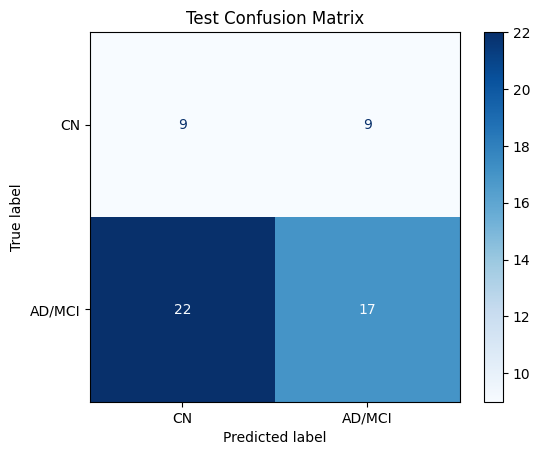

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Gather all labels & preds
all_labels = []
all_preds  = []
model.load_state_dict(torch.load('best3dcnn.pth', map_location=device))
model.eval()
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['CN','AD/MCI'])
disp.plot(cmap='Blues')
plt.title('Test Confusion Matrix')
plt.show()


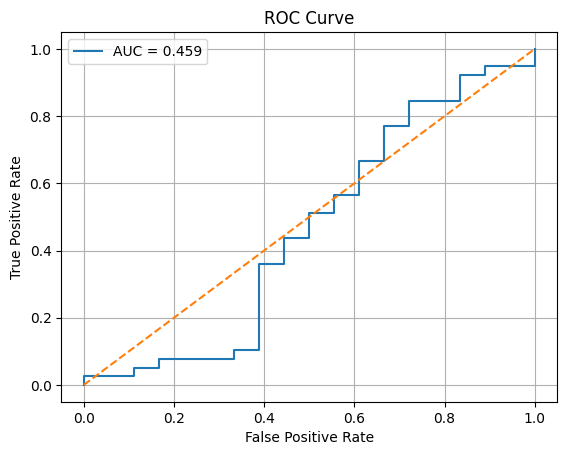

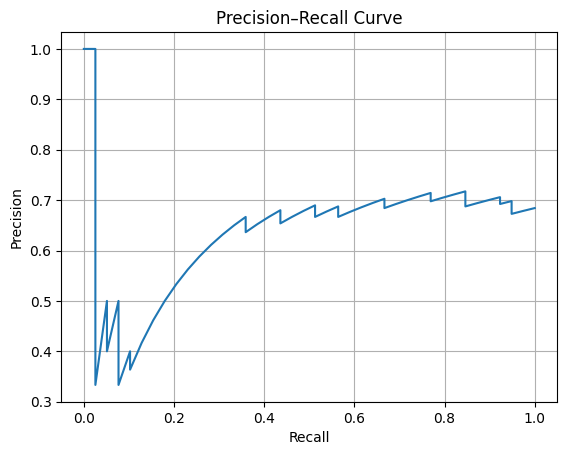

In [79]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1. Get prediction probabilities for the positive class
all_probs = []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        all_probs.extend(probs)

# 2. ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 3. Precision–Recall curve
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.grid(True)
plt.show()


Adjusting an balancing for imrove the results

Dataset, Transforms & Loaders

In [82]:
!pip install torchio
import torch, numpy as np
import torch.nn.functional as F
import nibabel as nib
import torchio as tio
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

patch_size = (96,128,96)

class VolumeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vol = nib.load(row.filepath).get_fdata().astype('float32')
        vol = (vol - vol.min()) / (np.ptp(vol) + 1e-6)
        vol = torch.from_numpy(vol)[None,...]
        subject = tio.Subject(t1=tio.ScalarImage(tensor=vol))
        if self.transform: subject = self.transform(subject)
        tensor = subject.t1.data.float()
        label  = torch.tensor(row.binary, dtype=torch.long)
        return tensor, label

train_transform = tio.Compose([
    tio.Resample((1,1,1)), tio.Resize(patch_size),
    tio.RandomFlip(), tio.RandomElasticDeformation(),
    tio.RandomBiasField(), tio.RandomMotion()
])
val_transform = tio.Compose([
    tio.Resample((1,1,1)), tio.Resize(patch_size)
])

def make_loader(csv, transform, batch_size=2):
    dfc = pd.read_csv(csv)
    # weighted sampler
    counts = dfc.binary.value_counts().sort_index().values
    cw     = 1.0/counts
    sw     = dfc.binary.map(lambda x: cw[x]).values
    sampler= WeightedRandomSampler(sw, len(sw), True)
    ds     = VolumeDataset(csv, transform=transform)
    return DataLoader(ds, batch_size=batch_size,
                      sampler=sampler if 'train' in csv else None,
                      shuffle=False if 'train' not in csv else False,
                      num_workers=2)

train_loader = make_loader('/content/train.csv', train_transform, batch_size=2)
val_loader   = make_loader('/content/val.csv',   val_transform,   batch_size=2)
test_loader  = make_loader('/content/test.csv',  val_transform,   batch_size=2)


Improved model and training

In [83]:
import torch.nn as nn, torch.optim as optim

class Basic3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1,16,3,padding=1);   self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16,32,3,padding=1);  self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32,64,3,padding=1);  self.bn3 = nn.BatchNorm3d(64)
        self.pool  = nn.MaxPool3d(2)
        flat = 64*(patch_size[0]//8)*(patch_size[1]//8)*(patch_size[2]//8)
        self.fc1   = nn.Linear(flat,128)
        self.drop  = nn.Dropout(0.4)
        self.fc2   = nn.Linear(128,2)
    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = Basic3DCNN().to(device)

# compute class weights once
train_df = pd.read_csv('/content/train.csv')
counts   = train_df.binary.value_counts().sort_index().values
cw       = torch.tensor([1.0/counts[0], 1.0/counts[1]],
                        dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.5,
                                                 patience=1,
                                                 verbose=True)

def train_epoch(loader):
    model.train(); total=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); optimizer.step()
        total += loss.item()
    return total/len(loader)

def eval_loader(loader):
    model.eval(); total=0; correct=0; n=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out  = model(x)
            total += criterion(out,y).item()
            preds  = out.argmax(1)
            correct += (preds==y).sum().item()
            n += y.size(0)
    return total/len(loader), correct/n


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [84]:
from sklearn.model_selection import StratifiedKFold
import copy, numpy as np

# Combine train+val for CV
df_tv = pd.concat([pd.read_csv('/content/train.csv'),
                   pd.read_csv('/content/val.csv')]).reset_index(drop=True)
X, y  = df_tv, df_tv.binary.values

skf = StratifiedKFold(5, shuffle=True, random_state=42)
fold_states = []

for fold,(ti,vi) in enumerate(skf.split(X,y),1):
    print(f"⏳ Fold {fold}/5")
    # subset CSVs
    X.iloc[ti].to_csv('/content/tmp_train.csv',index=False)
    X.iloc[vi].to_csv('/content/tmp_val.csv',  index=False)
    # rebuild loaders
    tl = make_loader('/content/tmp_train.csv', train_transform, batch_size=2)
    vl = make_loader('/content/tmp_val.csv',   val_transform,   batch_size=2)
    # fresh model & optim
    m  = Basic3DCNN().to(device)
    opt = optim.AdamW(m.parameters(), lr=1e-5, weight_decay=1e-5)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min',
                                                factor=0.5, patience=1)
    best_va = 0
    for ep in range(1,16):
        _ = train_epoch(tl)
        vl_loss, vl_acc = eval_loader(vl)
        sched.step(vl_loss)
        if vl_acc>best_va:
            best_va = vl_acc
            best_state = copy.deepcopy(m.state_dict())
    print(f"→ Fold {fold} best val acc {best_va:.3%}")
    fold_states.append(best_state)

# Ensemble on test set
all_probs, all_labels = [], []
for x,y in test_loader:
    x = x.to(device)
    batch_p = []
    for st in fold_states:
        model.load_state_dict(st)
        with torch.no_grad():
            out = model(x)
            p = torch.softmax(out,1)[:,1].cpu().numpy()
        batch_p.append(p)
    all_probs.extend(np.mean(batch_p,axis=0))
    all_labels.extend(y.numpy())

# Final metrics
preds = [1 if p>=0.5 else 0 for p in all_probs]
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print("Ensemble Acc:", accuracy_score(all_labels,preds))
print("Ensemble F1:", f1_score(all_labels,preds))
print("Ensemble AUC:", roc_auc_score(all_labels, all_probs))


⏳ Fold 1/5
→ Fold 1 best val acc 57.692%
⏳ Fold 2/5
→ Fold 2 best val acc 73.077%
⏳ Fold 3/5
→ Fold 3 best val acc 92.308%
⏳ Fold 4/5
→ Fold 4 best val acc 92.308%
⏳ Fold 5/5
→ Fold 5 best val acc 92.308%
Ensemble Acc: 0.3157894736842105
Ensemble F1: 0.0
Ensemble AUC: 0.4700854700854701


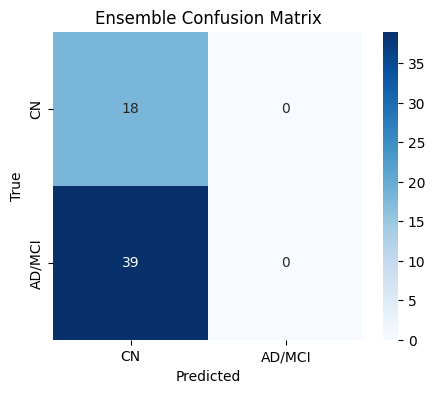

In [85]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn for heatmap convenience

cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CN","AD/MCI"],
            yticklabels=["CN","AD/MCI"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Ensemble Confusion Matrix")
plt.show()


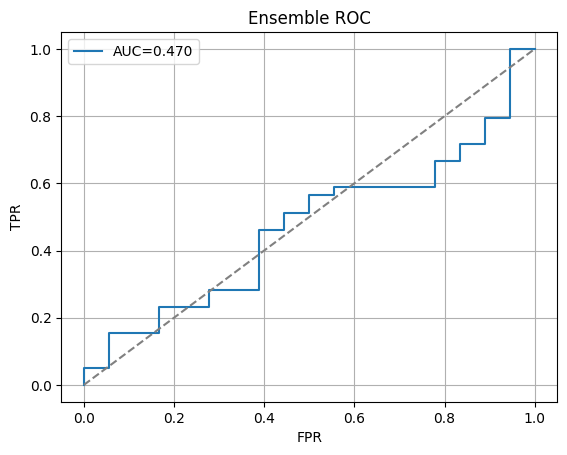

In [87]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(all_labels,all_probs):.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Ensemble ROC"); plt.legend(); plt.grid(); plt.show()



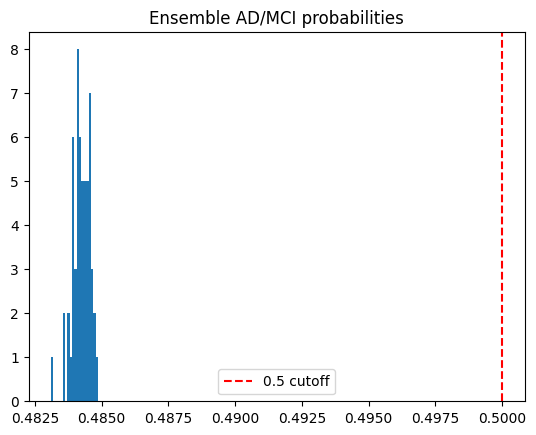

🔍 Best threshold = 0.00 → F1 = 0.812, Acc = 0.684
→ New ensemble Acc: 0.6842105263157895
→ New ensemble F1:  0.8125
→ New ensemble AUC: 0.4700854700854701
→ Vote Acc: 0.3157894736842105
→ Vote F1:  0.0
→ Vote AUC: 0.4700854700854701


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# 1) Plot the histogram of ensemble probabilities
plt.hist(all_probs, bins=20)
plt.axvline(0.5, color='red', linestyle='--', label='0.5 cutoff')
plt.title("Ensemble AD/MCI probabilities"); plt.legend(); plt.show()

# 2) Threshold sweep to maximize F1
ths = np.linspace(0,1,101)
best = {'th':None, 'f1':-1, 'acc':0}
for t in ths:
    preds_t = [1 if p>=t else 0 for p in all_probs]
    f1 = f1_score(all_labels, preds_t, zero_division=0)
    acc = accuracy_score(all_labels, preds_t)
    if f1 > best['f1']:
        best.update({'th':t, 'f1':f1, 'acc':acc})
print(f"🔍 Best threshold = {best['th']:.2f} → F1 = {best['f1']:.3f}, Acc = {best['acc']:.3f}")

# 3) Apply that threshold and report new metrics
t0 = best['th']
preds_opt = [1 if p>=t0 else 0 for p in all_probs]
print("→ New ensemble Acc:", accuracy_score(all_labels,preds_opt))
print("→ New ensemble F1: ", f1_score(all_labels,preds_opt))
print("→ New ensemble AUC:", roc_auc_score(all_labels, all_probs))

# 4) (Bonus) Majority‑vote ensemble
#    Each fold model casts a hard vote, we pick the class with >2 votes
from collections import Counter
hard_preds = []
for i in range(len(test_loader.dataset)):
    votes = []
    for st in fold_states:
        model.load_state_dict(st)
        x,_ = test_loader.dataset[i]  # single sample
        out = model(x.unsqueeze(0).to(device))
        votes.append(int(out.argmax(1).item()))
    hard_preds.append(Counter(votes).most_common(1)[0][0])

print("→ Vote Acc:", accuracy_score(all_labels, hard_preds))
print("→ Vote F1: ", f1_score(all_labels, hard_preds))
print("→ Vote AUC:", roc_auc_score(all_labels, all_probs))
